<a href="https://colab.research.google.com/github/ak-ghoul/Deep-Learning/blob/master/Initialization%26Activation_funcs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error
from tqdm import tqdm_notebook
import time
from IPython.display import HTML
import imageio
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder

In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', ['red','yellow','green','orange'])

In [0]:
np.random.seed(0)

In [55]:
data, labels = make_blobs(n_samples = 1000, n_features = 2, centers = 4, random_state = 0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


In [0]:
sb.set()

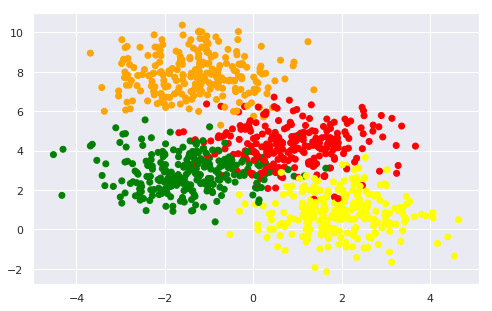

In [57]:

plt.figure(figsize = (8, 5))
plt.scatter(data[:,0], data[:,1], cmap = my_cmap, c = labels)  # c means the centres in which data points will be plotted. without c no different color will come
plt.show()

In [0]:
labels_orig = labels
labels = np.mod(labels, 2)

In [59]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify = labels_orig, random_state = 0)
print(X_train.shape, Y_train.shape)

(750, 2) (750,)


In [0]:
oh = OneHotEncoder()
Y_oh_train = oh.fit_transform(np.expand_dims(Y_train, 1)).toarray()
Y_oh_val = oh.fit_transform(np.expand_dims(Y_val, 1)).toarray()

In [0]:
class FFNNetwork:

  def __init__(self, activation_func = 'sigmoid', init_method = 'random', leaky_slope = 0.1):

    self.params = {}
    self.params_h = []
    self.num_layers = 2
    self.layer_size = [2,2,4]
    self.activation_function = activation_func
    self.leaky_slope = leaky_slope

    np.random.seed(0)

    if init_method == 'zeros':
      for i in range(1, self.num_layers+1):
        self.params['W'+str(i)] = np.zeros((self.layer_size[i-1], self.layer_size[i]))
        self.params['B'+str(i)] = np.zeros((1, self.layer_size[i]))

    if init_method == 'random':
      for i in range(1,self.num_layers+1):
        self.params['W'+str(i)] = np.random.randn(self.layer_size[i-1], self.layer_size[i])
        self.params['B'+str(i)] = np.random.randn(1,self.layer_size[i])
    
    if init_method == 'xavier':
      for i in range(1,self.num_layers+1):
        self.params['W'+str(i)] = np.random.randn(self.layer_size[i-1],self.layer_size[i])/np.sqrt(1/self.layer_size[i-1])
        self.params['B'+str(i)] = np.random.randn(1, self.layer_size[i])

    if init_method == 'he':
      for i in range(1,self.num_layers+1):
        self.params['W'+str(i)] = np.random.randn(self.layer_size[i-1],self.layer_size[i])/np.sqrt(2/self.layer_size[i-1])
        self.params['B'+str(i)] = np.random.randn(1, self.layer_size[i])

    self.gradients = {}
    self.update_params = {}
    self.prev_update_params = {}
    for i in range(1, self.num_layers+1):
      self.update_params['v_w'+str(i)] = 0
      self.update_params['v_b'+str(i)] = 0
      self.update_params['m_w'+str(i)] = 0
      self.update_params['m_b'+str(i)] = 0
      self.prev_update_params['v_w'+str(i)] = 0
      self.prev_update_params['v_b'+str(i)] = 0

  def forward_activation(self, X):
    if self.activation_function == 'sigmoid':
      return 1.0/(1.0 + np.exp(-X))
    elif self.activation_function == 'tanh':
      return np.tanh(X)
    elif self.activation_function == 'relu':
      return np.maximum(0, X)
    elif self.activation_function == 'leaky_relu':
      return np.maximum(self.leaky_slope*X, X)

    
  def grad_activation(self, X):

    if self.activation_function == 'sigmoid':
      return X*(1-X) 
    elif self.activation_function == 'tanh':
      return 1 - np.square(X)
    elif self.activation_function == 'relu':
      return 1.0 * (X>0)
    elif self.activation_function == 'leaky_relu':
      d = np.zeros_like(X)
      d[X>0] = 1
      d[X<=0] = self.leaky_slope
      return d
    
  def SoftMax(self, X):
    exps = np.exp(X)
    return exps/np.sum(exps, axis = 1).reshape(-1,1)

  def forward_pass(self, X, params = None):
    if params:
      self.params = params
    self.A1 = np.matmul(X, self.params["W1"]) + self.params["B1"] # (N, 2) * (2, 2) -> (N, 2)
    self.H1 = self.forward_activation(self.A1) # (N, 2)
    self.A2 = np.matmul(self.H1, self.params["W2"]) + self.params["B2"] # (N, 2) * (2, 4) -> (N, 4)
    self.H2 = self.SoftMax(self.A2) # (N, 4)
    return self.H2

  def grad(self, X, Y, params = None):
    if params:
      self.params = params
    self.forward_pass(X, params)
    m = X.shape[0]
    self.gradients["dA2"] = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
    self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2, N) * (N, 4) -> (2, 4)
    self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
    self.gradients["dH1"] = np.matmul(self.gradients["dA2"], self.params["W2"].T) # (N, 4) * (4, 2) -> (N, 2)
    self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
    self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2, 2)
    self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1) # (N, 2) -> (1, 2)

  def fit(self, X, Y, epochs = 10, lr = 1, beta=0.9,beta1=0.9,beta2=0.9,gamma=0.9,display_loss = True, algo='GD',mini_batch_size=100,eps=1e-8):
    
    if display_loss:
      loss = {}
    for i in tqdm_notebook(range(epochs), unit = 'epoch', total = epochs):
      m = X.shape[0]

      if algo == 'GD':
        self.grad(X, Y)
        for j in range(1,self.num_layers+1):
          self.params['W'+str(j)] -= lr * self.gradients['dW'+str(j)]/m
          self.params['B'+str(j)] -= lr * self.gradients['dB'+str(j)]/m
      
      elif algo == 'MiniBatch':
        for j in range(0, m, mini_batch_size):
          self.grad(X[j:j+mini_batch_size], Y[j:j+mini_batch_size])
          for k in range(1,self.num_layers+1):
            self.params['W'+str(k)] -= lr * self.gradients['dW'+str(k)]/mini_batch_size
            self.params['B'+str(k)] -= lr * self.gradients['dB'+str(k)]/mini_batch_size

      elif algo == 'Momentum':
        self.grad(X, Y)
        for j in range(1,self.num_layers+1):
          self.update_params['v_w'+str(j)] = self.update_params['v_w'+str(j)] * gamma + lr * self.gradients['dW'+str(j)]/m
          self.update_params['v_b'+str(j)] = self.update_params['v_b'+str(j)] * gamma + lr * self.gradients['dB'+str(j)]/m
          self.params['W'+str(j)] -= self.update_params['v_w'+str(j)]
          self.params['B'+str(j)] -= self.update_params['v_b'+str(j)]
      
      elif algo == 'NAG':
        temp_params = {}
        for j in range(1,self.num_layers+1):
          self.update_params['v_w'+str(j)] *= gamma
          self.update_params['v_b'+str(j)] *= gamma
          temp_params['W'+str(j)] = self.params['W'+str(j)] - self.update_params['v_w'+str(j)]
          temp_params['B'+str(j)] = self.params['B'+str(j)] - self.update_params['v_b'+str(j)]
        self.grad(X, Y, temp_params)
        for j in range(1,self.num_layers+1):
          self.update_params['v_w'+str(j)] += lr * self.gradients['dW'+str(j)]/m
          self.update_params['v_b'+str(j)] += lr * self.gradients['dB'+str(j)]/m
          self.params['W'+str(j)] -= lr * self.update_params['v_w'+str(j)]
          self.params['B'+str(j)] -= lr * self.update_params['v_b'+str(j)]
      
      elif algo == 'Adagrad':
        self.grad(X, Y)
        for j in range(1,self.num_layers+1):
          self.update_params['v_w'+str(j)] += (self.gradients['dW'+str(j)]/m) ** 2
          self.update_params['v_b'+str(j)] += (self.gradients['dB'+str(j)]/m) ** 2
          self.params['W'+str(j)] -= (lr/(np.sqrt(self.update_params['v_w'+str(j)])+ eps)) * self.gradients['dW'+str(j)]/m
          self.params['B'+str(j)] -= (lr/(np.sqrt(self.update_params['v_b'+str(j)])+ eps)) * self.gradients['dB'+str(j)]/m
      elif algo == 'RMSProp':
        self.grad(X, Y)
        for j in range(1,self.num_layers+1):
          self.update_params['v_w'+str(j)] = beta * self.update_params['v_w'+str(j)] + (1-beta) * (self.gradients['dW'+str(j)]/m)**2
          self.update_params["v_b"+str(j)] = beta*self.update_params["v_b"+str(j)] +(1-beta)*((self.gradients["dB"+str(j)]/m)**2)
          self.params["W"+str(j)] -= (lr/(np.sqrt(self.update_params["v_w"+str(j)]+eps)))*(self.gradients["dW"+str(j)]/m)
          self.params["B"+str(j)] -= (lr/(np.sqrt(self.update_params["v_b"+str(j)]+eps)))*(self.gradients["dB"+str(j)]/m)
      
      elif algo == 'Adam':
        self.grad(X, Y)
        num_updates = 0
        for j in range(1,self.num_layers+1):
          num_updates += 1
          self.update_params['v_w'+str(j)] = beta2 * self.update_params['v_w'+str(j)] + (1 - beta2) * (self.gradients['dW'+str(j)]/m)**2
          self.update_params['v_b'+str(j)] = beta2 * self.update_params['v_b'+str(j)] + (1 - beta2) * (self.gradients['dB'+str(j)]/m)**2
          self.update_params['m_w'+str(j)] = beta1 * self.update_params['v_w'+str(j)] + (1 - beta1) * (self.gradients['dW'+str(j)]/m)
          self.update_params['m_b'+str(j)] = beta1 * self.update_params['v_b'+str(j)] + (1 - beta1) * (self.gradients['dB'+str(j)]/m)
          m_w_c = self.update_params['m_w'+str(j)]/(1 - np.power(beta1, num_updates))
          m_b_c = self.update_params['m_b'+str(j)]/(1 - np.power(beta1, num_updates))
          v_w_c = self.update_params['v_w'+str(j)]/(1 - np.power(beta2, num_updates))
          v_b_c = self.update_params['v_b'+str(j)]/(1 - np.power(beta2, num_updates))
          self.params['W'+str(j)] -= (lr/(np.sqrt(v_w_c) + eps)) * m_w_c
          self.params['B'+str(j)] -= (lr/(np.sqrt(v_b_c) + eps)) * m_b_c 
      
      if display_loss:
        Y_pred = self.predict(X)
        loss[i] = log_loss(np.argmax(Y, axis = 1), Y_pred)
        self.params_h.append(np.concatenate((self.params['W1'].ravel(), self.params['W2'].ravel(), self.params['B1'].ravel(), self.params['B2'].ravel())))
    if display_loss:
      plt.plot(loss.values(), '-o', markersize = 5)
      plt.xlabel('Epochs')
      plt.ylabel('Log_loss')
      plt.show()

  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()
    

In [0]:
def post_predict(scatter_plot = False, gradient_plot = True, plot_scale = 0.1):
  Y_pred_train = ffn.predict(X_train)
  Y_pred_train = np.argmax(Y_pred_train, axis = 1)
  Y_pred_val = ffn.predict(X_val)
  Y_pred_val  = np.argmax(Y_pred_val, axis = 1)
  print('Trainig Accuracy:',accuracy_score(Y_train, Y_pred_train))
  print('Testing Accuracy:',accuracy_score(Y_val, Y_pred_val))

  if scatter_plot:
    plt.scatter(X_train[:,0], X_train[:,1], c = Y_pred_train, c_map = my_cmap, s = np.abs(np.sign(Y_pred_train-Y_train)+.1))
    plt.show()
  if gradient_plot:
    h = np.asarray(ffn.params_h)
    h_diff = (h[0:-1,:] - h[1:,:])
    for i in range(18):   # because we know this neural network has 18 parameters. 12 weights & 6 biases. 2 neurons in first layer & 4 in the output layer
      plt.subplot(6, 3, i+1)   # (number_of_rows, no_of_columns, index_of_plot)
      plt.plot(h_diff[:,i], '-')
      plt.xticks([])
      plt.yticks([])
      plt.ylim(-plot_scale, plot_scale)
    plt.show()


sigmoid zeros


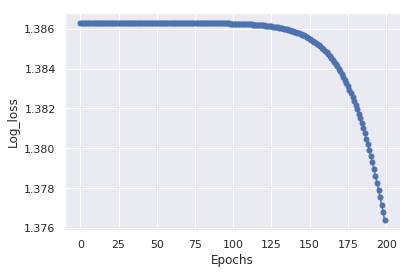

Trainig Accuracy: 0.25066666666666665
Testing Accuracy: 0.248


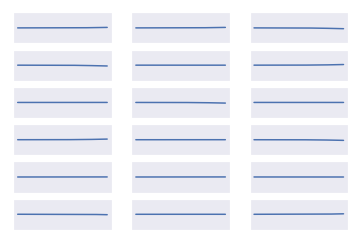


 --- 

sigmoid random


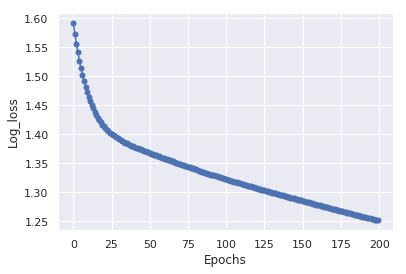

Trainig Accuracy: 0.4266666666666667
Testing Accuracy: 0.416


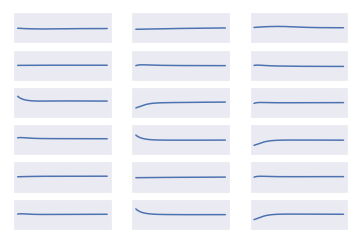


 --- 

sigmoid xavier


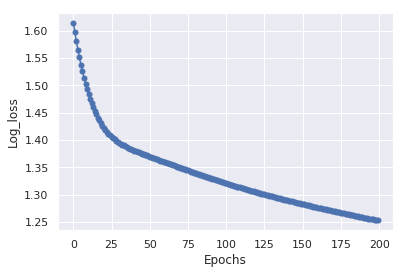

Trainig Accuracy: 0.4106666666666667
Testing Accuracy: 0.412


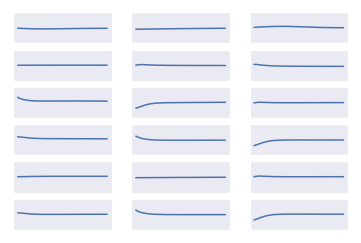


 --- 

sigmoid he


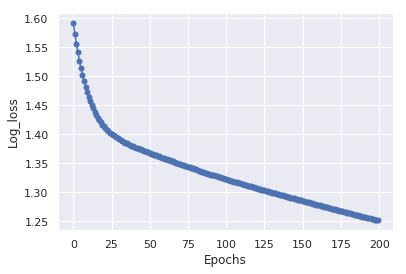

Trainig Accuracy: 0.4266666666666667
Testing Accuracy: 0.416


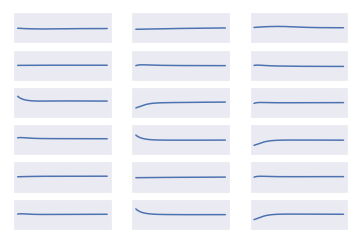


 --- 

tanh zeros


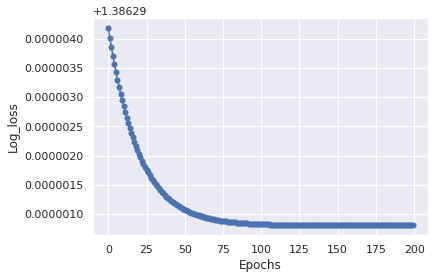

Trainig Accuracy: 0.25066666666666665
Testing Accuracy: 0.248


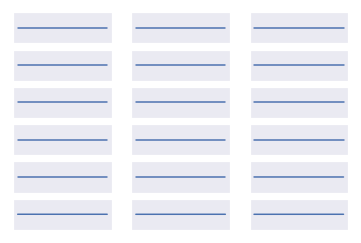


 --- 

tanh random


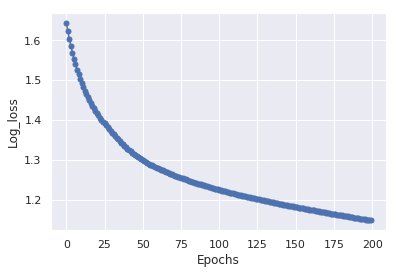

Trainig Accuracy: 0.4533333333333333
Testing Accuracy: 0.444


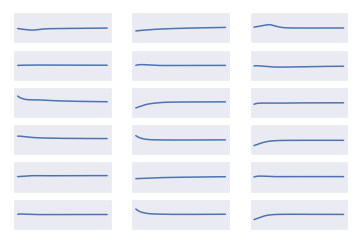


 --- 

tanh xavier


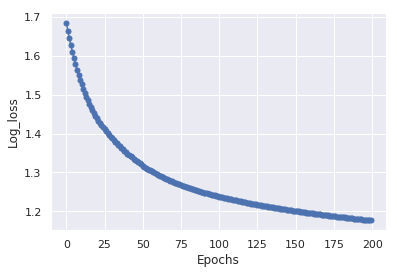

Trainig Accuracy: 0.4146666666666667
Testing Accuracy: 0.412


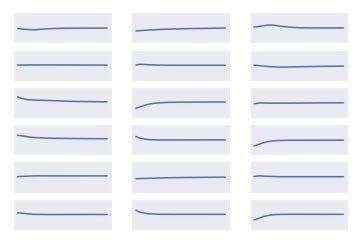


 --- 

tanh he


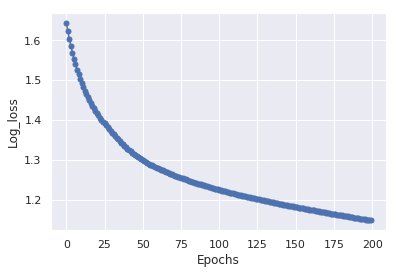

Trainig Accuracy: 0.4533333333333333
Testing Accuracy: 0.444


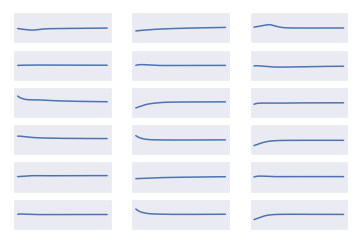


 --- 

relu zeros


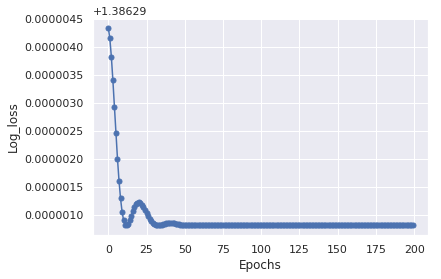

Trainig Accuracy: 0.25066666666666665
Testing Accuracy: 0.248


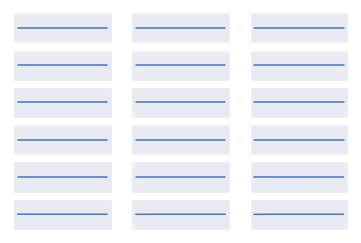


 --- 

relu random


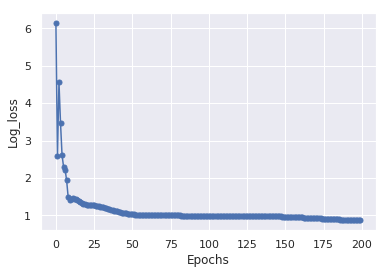

Trainig Accuracy: 0.5453333333333333
Testing Accuracy: 0.568


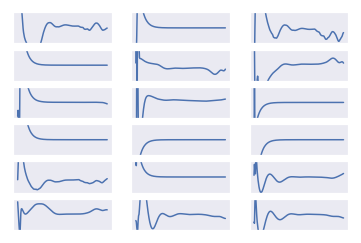


 --- 

relu xavier


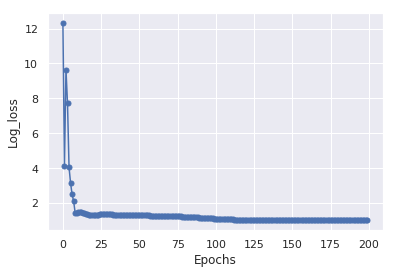

Trainig Accuracy: 0.46
Testing Accuracy: 0.456


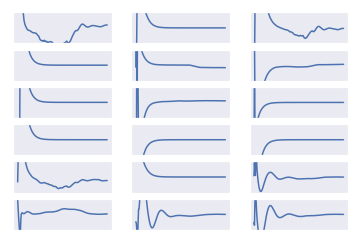


 --- 

relu he


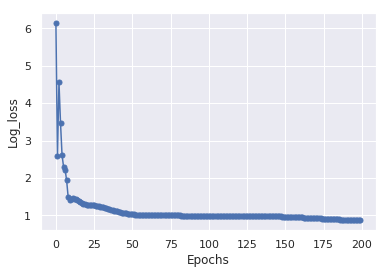

Trainig Accuracy: 0.5453333333333333
Testing Accuracy: 0.568


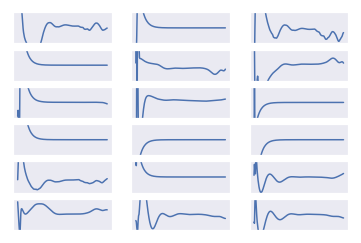


 --- 

leaky_relu zeros


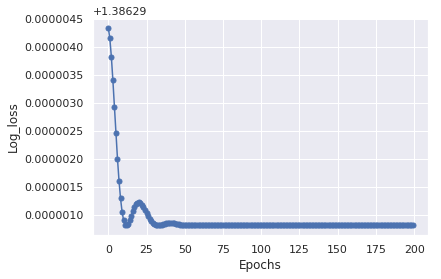

Trainig Accuracy: 0.25066666666666665
Testing Accuracy: 0.248


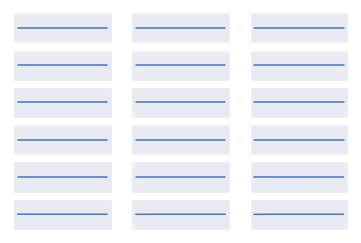


 --- 

leaky_relu random


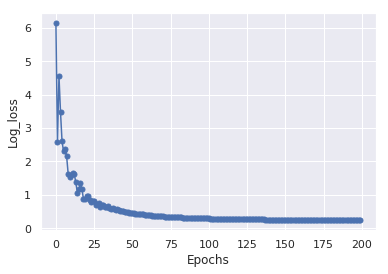

Trainig Accuracy: 0.9186666666666666
Testing Accuracy: 0.944


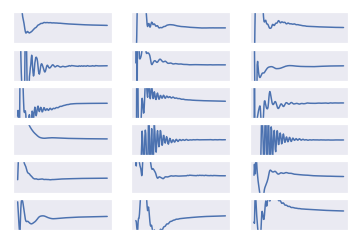


 --- 

leaky_relu xavier


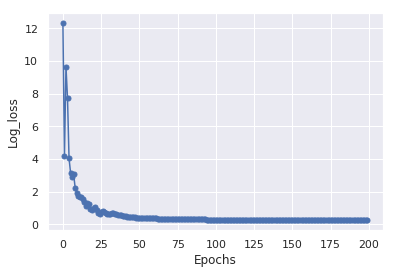

Trainig Accuracy: 0.9213333333333333
Testing Accuracy: 0.948


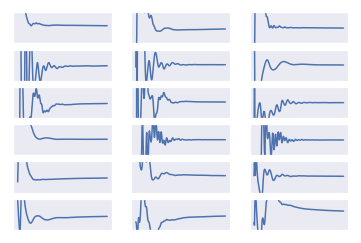


 --- 

leaky_relu he


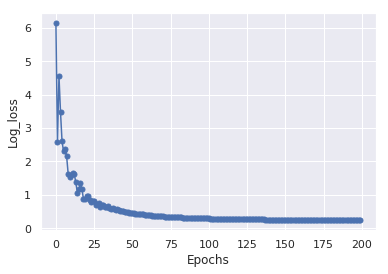

Trainig Accuracy: 0.9186666666666666
Testing Accuracy: 0.944


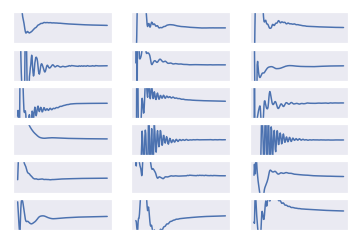


 --- 



In [66]:
for activation_function in ['sigmoid', 'tanh', 'relu', 'leaky_relu']:
  for init_method in ['zeros', 'random', 'xavier', 'he']:
    print(activation_function, init_method)
    ffn = FFNNetwork(activation_func = activation_function, init_method = init_method) 
    if activation_function == 'sigmoid':   # if condition for every activation_function so that we can change algorithm individually for maximum accuracy
      ffn.fit(X_train, Y_oh_train, epochs = 200, lr = 0.1, algo = 'GD')
    elif activation_function == 'tanh':
      ffn.fit(X_train, Y_oh_train, epochs = 200, lr = 0.1, algo = 'GD')
    elif activation_function == 'relu':
      ffn.fit(X_train, Y_oh_train, epochs = 200, lr = 0.1, algo = 'NAG')
    elif activation_function == 'leaky_relu':
      ffn.fit(X_train, Y_oh_train, epochs = 200, lr = 0.1, algo = 'NAG')
    post_predict(plot_scale = 0.05)
    print('\n --- \n')
  print('================================')
